<a href="https://colab.research.google.com/github/jdasam/mas1004-2023/blob/main/live_coding/7_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST classification with CNN


In [1]:
!pip install tqdm

import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# make plt grayscale as default
plt.rcParams['image.cmap'] = 'gray'

DEV = 'cuda' # Use GPU # library for NVIDIA GPU
assert torch.cuda.is_available(), "Make sure you run this Colab in GPU"

## 0. Download Dataset

In [2]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 108889389.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114603305.42it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29185655.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17871040.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# See how our data looks like
# you can get the i-th data from the dataset class using dataset[i]
train_data[0] # this will return (image tensor, label)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Label is 8


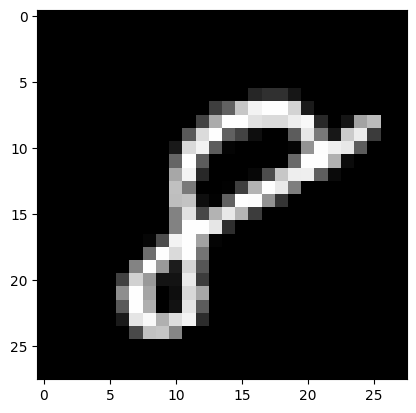

In [4]:
data_idx = 59999
# You can load the data sample from the dataset, using [idx]
img, label = train_data[data_idx] # get the data_idx-th sample from the train_data
img = img.squeeze()

plt.imshow(img), # plt.imshow visualize 2D image
print(f'Label is {label}') # f means formatted string

tensor([[ 1,  1,  1],
        [ 0,  0,  0],
        [-1, -1, -1]])


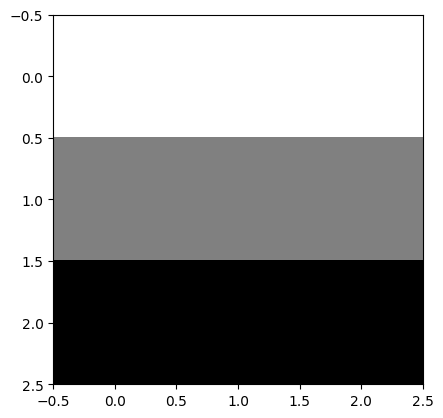

In [5]:
# make simple kernel and apply it to the image
# plt.imshow(img[10:13, 10:13])
sliced_input = img[10:13, 10:13]

custom_kernel = torch.tensor([[1, 1, 1], [0, 0, 0], [-1, -1, -1] ])
print(custom_kernel)
plt.imshow(custom_kernel)
# kernel_output = (sliced_input * custom_kernel).sum() # take the element-wise multiplication and take sum
# kernel_output

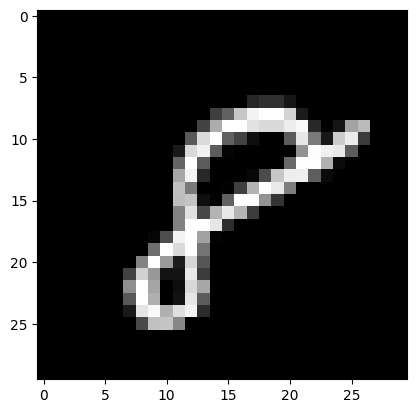

In [6]:
pad_size = 1
padded_img = torch.zeros(img.shape[0] + pad_size * 2, img.shape[1] + pad_size *2 )
padded_img.shape
padded_img[pad_size:-pad_size, pad_size:-pad_size] = img
plt.imshow(padded_img)

In [7]:
# We will move our kernel throughout the image and see the result
kernel_size = 3

total_outputs = []
img = padded_img
for h in range(img.shape[0] - (kernel_size -1) ):
  row_output = []
  for w in range(img.shape[1] - (kernel_size -1) ):
    sliced_img = img[h:h+3, w:w+3]
    convolution_output = (sliced_img * custom_kernel).sum().item()
    # print(convolution_output)
    row_output.append(convolution_output)
  # print(row_output)
  total_outputs.append(row_output)
total_outputs = torch.tensor(total_outputs)
total_outputs.shape

torch.Size([28, 28])

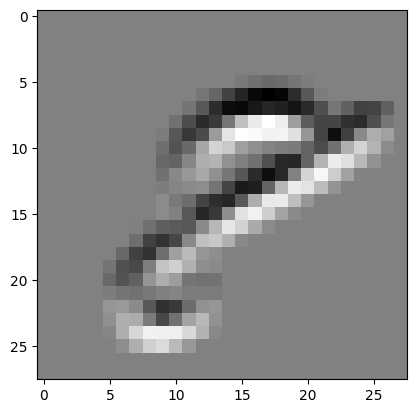

In [8]:
plt.imshow(total_outputs)

# 0.0 Using DataLoader

In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
class Dataset:
  def __init__(self, data):
    self.data = data

  # To implement the dataset, you have to declare two methods
  # __getitem__ and __len__

  def __getitem__(self, idx):
    # this method is called when you do train_set[idx]
    # here, we want to return our idx-th datasample, in proper format
    img, label = self.data[idx]
    # return img, label
    return img, label

  def __len__(self):
    # how many datasample we have in our dataset?
    # what is the maximum valid idx for __getitem__
    return len(self.data)

train_set = Dataset(train_data)
# train_set[15]
print(len(train_set))
img, label = train_set[0]
img.shape

60000


torch.Size([1, 28, 28])

In [50]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)

for batch in train_loader:
  imgs, labels = batch
  break
imgs.shape


torch.Size([16, 1, 28, 28])

## 1. Make a Model

In [91]:
class MLPClassifier(nn.Module):
  def __init__(self, input_dim=784, num_class=10):
    super().__init__()
    # Let's make three layer models

    # What we know: input_dim = 784
    # number_of_categories = 10
    hidden_dim = 64
    hidden_dim2 = 64

    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, hidden_dim2)
    self.layer3 = nn.Linear(hidden_dim2, hidden_dim2)
    self.layer4 = nn.Linear(hidden_dim2, hidden_dim2)
    self.layer5 = nn.Linear(hidden_dim2, num_class)

    # self.layers = nn.Sequential(
    #     nn.Linear(input_dim, hidden_dim)
    #     nn.ReLU()
    # )
    # self.layer = nn.Linear(784, 123)

  def forward(self, x): # x is an input
    # x is a tensor with a shape of [Num samples, 784]

    # we want to predict the probability of each category label for a given input
    # we have 10 different categories in our dataset
    if x.ndim >= 3:
      x = x.reshape(x.shape[0], -1) # batch_size, -1
    x = self.layer1(x)
    x = x.relu()
    x = self.layer2(x)
    x = x.relu()
    x = self.layer3(x).relu()
    x = self.layer4(x).relu()
    logit = self.layer5(x)
    prob = logit.softmax(dim=-1)
    return prob


test_model = MLPClassifier()

torch.set_printoptions(sci_mode=False)
print(imgs.shape)
pred= test_model(imgs)
pred.shape
# get_number_of_parameters(test_model)

torch.Size([16, 1, 28, 28])


63370

In [66]:
class CNNClassifier(nn.Module):
  def __init__(self, channel_size=32, num_class=10):
    super().__init__()
    # Let's make three layer models

    # What we know: input_dim = 784
    # number_of_categories = 10
    hidden_dim = 64
    hidden_dim2 = 32

    self.layer1 = nn.Conv2d(in_channels=1,
                            out_channels=channel_size//2,
                            kernel_size=3,
                            padding=1)
    self.layer2 = nn.Conv2d(in_channels=channel_size//2,
                            out_channels=channel_size,
                            kernel_size=3,
                            padding=1)
    self.layer3 = nn.Conv2d(in_channels=channel_size,
                            out_channels=channel_size*2,
                            kernel_size=3,
                            padding=1)
    self.layer4 = nn.Conv2d(in_channels=channel_size*2,
                        out_channels=channel_size*2,
                        kernel_size=3)

    self.pool = nn.MaxPool2d(kernel_size=2)
    self.final_pool = nn.AdaptiveMaxPool2d(output_size=1)
    self.proj = nn.Linear(channel_size * 2, num_class)


  def forward(self, x): # x is an input
    # x is a tensor with a shape of [Num samples, 784]

    # we want to predict the probability of each category label for a given input
    # we have 10 different categories in our dataset
    x = self.layer1(x)
    # print(x.shape)
    x = self.pool(x)
    # print(x.shape)
    x = x.relu()
    x = self.layer2(x)
    # print(x.shape)
    x = self.pool(x)
    # print(x.shape)
    x = x.relu()
    x = self.layer3(x)
    # print(x.shape)
    x = x.relu()
    x = self.layer4(x)
    x = x.relu()
    # print(x.shape)
    x = self.final_pool(x)
    x = x.squeeze()
    logit = self.proj(x)
    prob = logit.softmax(dim=-1)
    return prob
    # prob = logit.softmax(dim=-1)
    # return prob, logit

cnn_model = CNNClassifier()
out = cnn_model(imgs)
out.shape, out

(torch.Size([16, 10]),
 tensor([[0.1057, 0.0959, 0.0891, 0.1015, 0.0908, 0.1058, 0.0963, 0.1100, 0.0936,
          0.1113],
         [0.1054, 0.0958, 0.0893, 0.1017, 0.0909, 0.1046, 0.0967, 0.1105, 0.0939,
          0.1113],
         [0.1049, 0.0960, 0.0892, 0.1018, 0.0911, 0.1046, 0.0972, 0.1101, 0.0940,
          0.1112],
         [0.1047, 0.0956, 0.0891, 0.1022, 0.0915, 0.1045, 0.0970, 0.1102, 0.0939,
          0.1112],
         [0.1049, 0.0954, 0.0890, 0.1014, 0.0911, 0.1048, 0.0968, 0.1108, 0.0942,
          0.1117],
         [0.1054, 0.0962, 0.0894, 0.1014, 0.0906, 0.1052, 0.0966, 0.1102, 0.0937,
          0.1114],
         [0.1049, 0.0957, 0.0894, 0.1019, 0.0910, 0.1048, 0.0965, 0.1103, 0.0940,
          0.1114],
         [0.1054, 0.0960, 0.0891, 0.1013, 0.0909, 0.1051, 0.0967, 0.1104, 0.0936,
          0.1116],
         [0.1051, 0.0960, 0.0888, 0.1011, 0.0907, 0.1050, 0.0968, 0.1105, 0.0942,
          0.1117],
         [0.1047, 0.0955, 0.0896, 0.1016, 0.0913, 0.1049, 0.0965, 0.

In [ ]:
layer = nn.Conv2d(in_channels=1, out_channels=7, kernel_size=3, padding=1, stride=1)
out = layer(imgs)
print(imgs.shape, out.shape)
out[3, :, 7, 7] # 3rd sample of the batch, entire channel, 14th pixel in height, 14th pixel in width

In [47]:
pool = nn.MaxPool2d(kernel_size=2)

test_example = torch.arange(24).reshape(1, 1, 4, 6)
print(test_example)
print(pool(test_example))

tensor([[[[ 0,  1,  2,  3,  4,  5],
          [ 6,  7,  8,  9, 10, 11],
          [12, 13, 14, 15, 16, 17],
          [18, 19, 20, 21, 22, 23]]]])
tensor([[[[ 7,  9, 11],
          [19, 21, 23]]]])


## 2. Training

### 2.1 Make a Loss Function
- Define Negative Log Likelihood Loss
  - $L = -\sum_{i=1}^n\log(\hat{y}_{i}^{(c)})$
  - $y_{i}^{(c)} \in (0, 1)$: predicted probability for $i$-th sample to be class $c$, where $c$ is the ground truth label for $i$-th sample
- Define Cross Entropy Loss
  - $L = -\sum_{i=1}^ny_{i}\log(\hat{y}_{i})$
  - $ y_{i} \in (0,1)^C$: ground truth label for $i$-th sample to be class $c$. $C$ denotes the number of classes.
    - One-hot encoding: $y_{i} = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$
  - $ \hat{y}_{i} \in (0, 1)^C$: predicted probability for $i$-th sample to be class $c$
    - e.g.: $\hat{y}_{i} = [0.1, 0.1, 0.5, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1]$

In [67]:
def get_negative_log_likelihood(pred, target, eps=1e-8):
  predicted_probs = []
  # for i in range(len(pred)): #len(pred) means number of samples, or pred.shape[0]
  #   i_th_pred = pred[i]
  #   correct_label = target[i]
  #   predicted_prob_for_correct_class = i_th_pred[correct_label]
  #   # print(i_th_pred, correct_label, predicted_prob_for_correct_class)
  #   predicted_probs.append(predicted_prob_for_correct_class)

  # predicted_probs = torch.tensor(predicted_probs)
  predicted_probs = pred[torch.arange(len(target)), target]
  return -torch.log(predicted_probs + eps).mean()

def get_cross_entropy(pred, target, eps=1e-8):
  return

def make_one_hot_vector(target, num_class=10):
  return

# pred.shape, label_tensor.shape
# print(pred[:5])
# print(label_tensor[:5])

# predicted_probs = []
# for i in range(len(pred)): #len(pred) means number of samples, or pred.shape[0]
#   i_th_pred = pred[i]
#   correct_label = label_tensor[i]
#   predicted_prob_for_correct_class = i_th_pred[correct_label]
#   # print(i_th_pred, correct_label, predicted_prob_for_correct_class)
#   predicted_probs.append(predicted_prob_for_correct_class)

# predicted_probs = torch.tensor(predicted_probs)

loss = get_negative_log_likelihood(out, labels)
loss

tensor(2.3046, grad_fn=<NegBackward0>)

### 2.2 Define Training Loop

In [70]:
def train_one_step(model, optimizer, loss_function, input, target):
  pred = model(input) # forward pass. compute the prediction
  loss = loss_function(pred, target) # compute the loss
  loss.backward() # backpropagate theloss. compute the gradient
  optimizer.step() # update the parameters based on each gradient
  optimizer.zero_grad() # clear the gradient for every parameters
  return loss.item() # return the loss value


### 2.4 Train

In [ ]:
DEV

In [74]:
model = CNNClassifier()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = get_negative_log_likelihood

losses = []
num_epochs = 5

model.to(DEV) # move model to cuda. Move model's parameter on GPU's VRAM

for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_loader, leave=False):
    input_batch, target_batch = batch
    input_batch = input_batch.to(DEV)  # Movetensor to GPU's VRAM
    target_batch = target_batch.to(DEV)
    loss = train_one_step(model, optimizer, loss_function, input_batch, target_batch)
    losses.append(loss)




  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

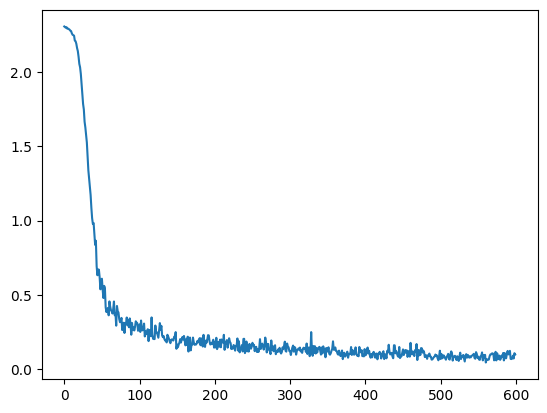

In [72]:
plt.plot(losses)

In [92]:
mlp_model = MLPClassifier()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
loss_function = get_negative_log_likelihood

mlp_losses = []
num_epochs = 5

mlp_model.to(DEV) # move model to cuda. Move model's parameter on GPU's VRAM

for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_loader, leave=False):
    input_batch, target_batch = batch
    input_batch = input_batch.to(DEV)  # Movetensor to GPU's VRAM
    target_batch = target_batch.to(DEV)
    loss = train_one_step(mlp_model, mlp_optimizer, loss_function, input_batch, target_batch)
    mlp_losses.append(loss)




  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

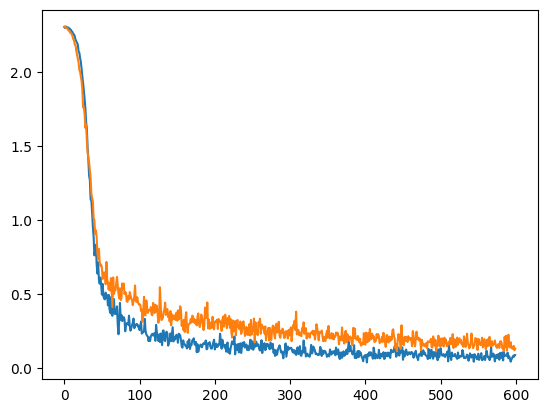

In [93]:
plt.plot(losses)
plt.plot(mlp_losses)

In [87]:
# number of layers in the model
# number of parameters in the model

def get_number_of_parameters(model):

  return sum([param.numel() for name, param in model.named_parameters()])

# get_number_of_parameters(model)
# get_number_of_parameters(mlp_model)

[(name, param.numel()) for name, param in mlp_model.named_parameters()]
[(name, param.numel()) for name, param in model.named_parameters()]

[('layer1.weight', 144),
 ('layer1.bias', 16),
 ('layer2.weight', 4608),
 ('layer2.bias', 32),
 ('layer3.weight', 18432),
 ('layer3.bias', 64),
 ('layer4.weight', 36864),
 ('layer4.bias', 64),
 ('proj.weight', 640),
 ('proj.bias', 10)]

In [126]:
test_loader = torch.utils.data.DataLoader(Dataset(test_data), batch_size=5000, shuffle=False)

test_batch = next(iter(test_loader))
# this will make something like "batch in test_loader" (iterator)
# and only gets the first one
imgs, labels = test_batch
# imgs.shape

pred = model(imgs.to(DEV))
# pred = mlp_model(imgs.to(DEV))
# pred = mlp_model(shift_image(imgs, pixel_amount=2).to(DEV))
# pred = model(shift_image(imgs, pixel_amount=5).to(DEV))

predicted_labels = torch.argmax(pred, dim=1).cpu()
acc = (predicted_labels == labels).sum().item() / len(labels)
acc

0.9654

In [121]:
def shift_image(imgs, pixel_amount=3):
  shifted_imgs = torch.zeros_like(imgs)
  shifted_imgs[:, :, pixel_amount: , pixel_amount: ] = imgs[:,:, :-pixel_amount, :-pixel_amount]
  return shifted_imgs

shifted_imgs = shift_image(imgs, 5)

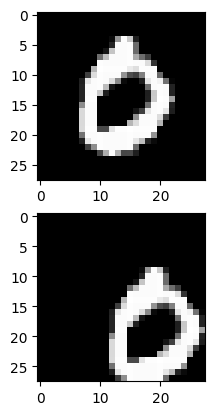

In [123]:
idx = 3

plt.subplot(2,1,1)
plt.imshow(imgs[idx,0])
plt.subplot(2,1,2)
plt.imshow(shifted_imgs[idx,0])

In [ ]:
pred[0:3]

In [ ]:
# torch.argmax
# return the indices that has maximum value
predicted_labels = torch.argmax(pred, dim=1).cpu()
predicted_labels[:10]

In [ ]:
(predicted_labels == labels).sum().item() / len(labels)

In [127]:
torch.where(predicted_labels != labels)
# it gives in which indices our model made wrong predictions

(tensor([  62,   73,   92,  184,  195,  241,  259,  318,  320,  321,  359,  412,
          445,  448,  497,  582,  583,  613,  619,  646,  659,  717,  720,  740,
          813,  882,  951,  956,  959,  965, 1014, 1039, 1044, 1112, 1156, 1182,
         1192, 1212, 1226, 1232, 1247, 1299, 1319, 1393, 1395, 1403, 1429, 1453,
         1522, 1530, 1549, 1553, 1569, 1581, 1621, 1626, 1681, 1709, 1748, 1800,
         1868, 1878, 1901, 1952, 1982, 2018, 2035, 2043, 2098, 2118, 2129, 2130,
         2135, 2148, 2182, 2185, 2189, 2266, 2293, 2369, 2380, 2386, 2387, 2406,
         2447, 2454, 2496, 2610, 2654, 2713, 2780, 2810, 2860, 2944, 2979, 2995,
         3005, 3030, 3060, 3073, 3100, 3132, 3222, 3240, 3330, 3344, 3369, 3422,
         3436, 3450, 3503, 3520, 3534, 3550, 3558, 3597, 3681, 3702, 3716, 3726,
         3762, 3767, 3808, 3811, 3821, 3869, 3871, 3902, 3906, 3926, 3985, 3996,
         4063, 4065, 4078, 4123, 4176, 4205, 4207, 4212, 4224, 4238, 4248, 4265,
         4271, 4289, 4300, 4

GT Label: 6, Predicted: 8


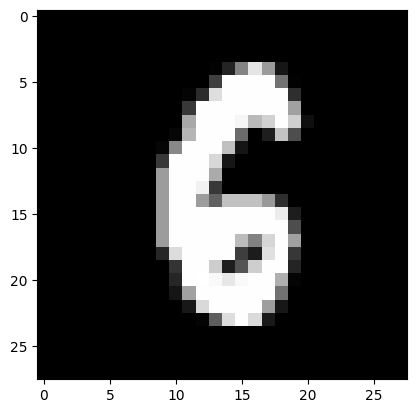

In [130]:
idx = 4619
img, label = test_data[idx]
predicted_lb = predicted_labels[idx].item()

print(f"GT Label: {label}, Predicted: {predicted_lb}")
plt.imshow(img.squeeze())

In [132]:
layer_output = model.layer1(imgs.to(DEV)).cpu()

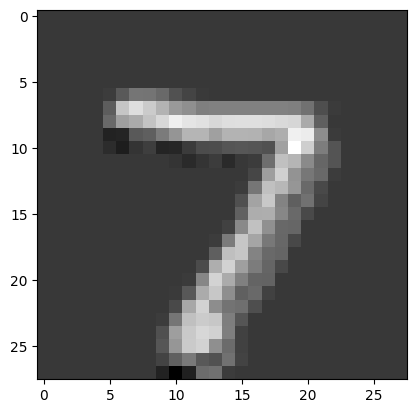

In [139]:
plt.imshow(layer_output[0, 5].detach())